##### **Name:** Rohan Karthikeyan
##### **Roll Number:** MDS202226

In this assignment, we will be performing model-based collaborative filtering using the Singular Value Decomposition algo.

> We will also be working with LensKit, a set of Python tools for training, running, and evaluating recommender algorithms.

In [1]:
!pip install lenskit --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 2023.621.222118 requires jupyter-server~=1.16, but you have jupyter-server 2.6.0 which is incompatible.
fitter 1.6.0 requires pandas<3.0.0,>=2.0.3, but you have pandas 1.5.3 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.11.2 which is incompatible.
ydata-profiling 4.3.1 requires scipy<1.11,>=1.4.1, but you have scipy 1.11.2 which is incompatible.


In [2]:
# Import necessary modules
import numpy as np
import pandas as pd

from lenskit import batch, topn, util
from lenskit import crossfold as xf

from lenskit.algorithms import Recommender
from lenskit.algorithms.basic import Fallback
from lenskit.algorithms.bias import Bias
from lenskit.algorithms.ranking import TopN
from lenskit.algorithms.svd import BiasedSVD as SVD

from lenskit.metrics.predict import rmse, user_metric

### Data preparation

Though the MovieLens 25M Dataset has a lot of additional datasets, we primarily use the `ratings` dataset which has the following columns:
* `userId` - user identifiers,
* `movieId` - movie (item) identifiers,
* `rating` - user ratings

In [3]:
ratings = pd.read_csv('../input/movielens-25m-dataset/ml-25m/ratings.csv', header=0,
                      names=['user', 'item', 'rating', 'timestamp'])
ratings

,user,item,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434


### Preparing for evaluation

In LensKit, evaluation proceeds in 2 steps:
1. Generate recommendations
2. Measure them

Not all algorithms generate recommendations, hence we wrap it with `TopN`. This is a basic recommender that implements top-N recommendation using a predictor.

In [4]:
def evaluate(train, test, algo):
    '''
    Generate recommendations over a single partition of the data set.

    Returns:
    -------
    recs (pd.DataFrame): A dataframe of of recommendations
    '''
    cloned_algo = util.clone(algo)  # Clone the algorithm, not its fitted data
    fittable = TopN(cloned_algo)
    fittable.fit(train)  # Fit the training set

    # Get 15 recommendations for all users in test set
    users_to_rec = test.user.unique()
    recs = batch.recommend(algo=fittable, users=users_to_rec, n=15)
    return recs

### Generate recommendations

To prepare data sets for cross-validation, we use the `partition_users` function: this splits the dataframe into train and test splits on a user-by-user basis. <br> The algorithm used is as follows:
1. Sample or partition the set of user IDs into $n$ sets of test users (here, $n=10$).
2. For each set of test users, select a set of that user’s rows to be test rows.
3. **Create a training set for each test set consisting of the non-selected rows from each** of that set’s test users, along with all rows from each non-test user.

We randomly select a fraction (here, 10%) of test rows per user/item.

**IMPORTANT NOTE:** The algorithm runs for a long time with the full data set of 25M rows (corresponding to 162.5K users). So, we only work with the first 16.25K users (i.e., the first 10%).

In [5]:
# Our algorithm: Perform truncated SVD with 40 features
svd = SVD(features=40)

In [6]:
%%time

small = ratings[ratings.user < 16251].copy()
test_data = []

for train, test in xf.partition_users(data=small[['user', 'item', 'rating']],
                                      partitions=10, method=xf.SampleFrac(0.1)):
    test_data.append(test)
    recs = evaluate(train, test, svd)  # Run the evaluation fn.

# Get first few rows of recommendations
recs.head(7)

CPU times: user 1min 14s, sys: 39.7 s, total: 1min 54s
Wall time: 6min 42s


,item,score,user,rank
0,179135,5.024051,14,1
1,170705,5.014077,14,2
2,171011,4.999992,14,3
3,318,4.998594,14,4
4,171495,4.958108,14,5
5,159817,4.956197,14,6
6,179173,4.946438,14,7


### Evaluate recommendations

We require two data frames for analysis: 
* The _recommendation frame_ contains the recommendations themselves, and 
* The _truth frame_ contains the ground truth data for the users.

We analyze our recommendation lists with a `RecListAnalysis`. This takes care of the hard work of making sure that the truth data (our test data) and the recommendations line up properly.

In [7]:
rla = topn.RecListAnalysis()

# Add metrics for computing precision and recall
# Consider only top 6 recommendations for evaluation
rla.add_metric(topn.precision, k=6)
rla.add_metric(topn.recall, k=6)

# Concatenate test data for evaluation
test_data = pd.concat(test_data, ignore_index=True)

# Run the analysis
results = rla.compute(recs, test_data)
results

,nrecs,precision,recall
user,,,
14,15,0.000000,0.000000
16,15,0.000000,0.000000
43,15,0.166667,0.166667
46,15,0.000000,0.000000
47,15,0.166667,0.166667
...,...,...,...
16215,15,0.166667,0.166667
16224,15,0.000000,0.000000
16234,15,0.000000,0.000000


<Axes: xlabel='precision', ylabel='recall'>

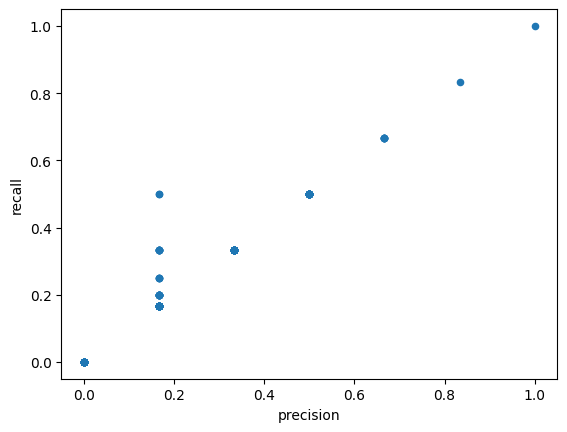

In [8]:
# Scatter plot
results.plot(x='precision', y='recall', kind='scatter')

**Observation:** Very interestingly, many users have the same value of precision and recall other than a small band of increasing recall values at precision ~ 16.67%. <br>I do not attempt to analyze the cause behind this behaviour.

### Generate and evaluate predictions

We do not need to sweat much to prepare data for generating predictions, unlike earlier where we did cross-validation. <br>We simply take the first 100K rows as the test set, and use the remaining for training.

Sometimes, when the core model (here, the SVD algo.) is unable to predict, it returns a NaN for the predicted rating. This is a problem when computing predictive accuracy: recommenders are not being tested on the same set of items. 

To solve this problem, LensKit advises to use a *fallback predictor* so that every item will have a prediction: it takes a list of composite algorithms, and uses the first one to return a result to predict the rating for each item.

We employ a `Bias` predictor as our fallback: it gives a personalized mean rating prediction.

In [9]:
%%time
# Make the train-test split
train = ratings.iloc[100000:]
test = ratings.iloc[:100000]

# Fit our SVD algorithm
base = Bias(damping=5)
algo = Fallback(svd, base)
algo.fit(train)

# Compute predictions
preds = batch.predict(algo, test)
preds

CPU times: user 38.6 s, sys: 25.9 s, total: 1min 4s
Wall time: 1min 8s


,user,item,rating,timestamp,prediction
0,1,296,5.0,1147880044,4.188991
1,1,306,3.5,1147868817,4.072143
2,1,307,5.0,1147868828,3.980410
3,1,665,5.0,1147878820,3.942425
4,1,899,3.5,1147868510,4.051218
...,...,...,...,...,...
99995,757,2115,3.0,1184014093,3.661906
99996,757,2117,3.0,1184015776,3.796182
99997,757,2118,4.0,1184014221,3.834818
99998,757,2124,3.5,1184073900,3.420602


In [10]:
# Calculate global RMSE
global_rmse = rmse(preds['prediction'], preds['rating'])
print('The global RMSE of the model is {:.3f}.'.format(global_rmse))

# Calculate mean of per-user RMSE
mean_user_rmse = user_metric(preds, metric=rmse)
print('The mean per-user RMSE of the model is {:.3f}.'.format(mean_user_rmse))

The global RMSE of the model is 0.955.
The mean per-user RMSE of the model is 0.946.
